In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.signal import convolve2d

import re
import cv2
import torch
import torch.nn as nn
import numpy as np
import torch
from torch.utils.data import Dataset
#
directory = "spectrogram"

In [13]:
batch_size = 10
num_classes = 2
learning_rate = 0.001
num_epochs = 15

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
def load_images(dossier):
    X1, X0 = [], []
    for fichier in os.listdir(dossier):
        f = os.path.join(dossier, fichier)
        # n = [float(s) for s in re.findall(r"-?\d+\.?\d*", f)]
        # if n[0] < 1600:
        #     img = Image.open(f).convert('L')
        #     img = np.array(img)
        #     X0.append(img[400:550])
        # else:
        img = Image.open(f).convert('L')
        img = np.array(img)
        X1.append(img)
    return np.array(X1), np.array(X0)

In [24]:
X1, X0 = load_images(directory)

In [25]:
X1.shape

(143, 636, 1570)

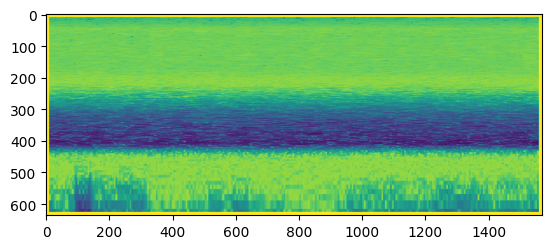

In [26]:
plt.imshow(X1[30])

In [7]:
X1 = np.stack((X1[:,:,:,0], X1[:,:,:,1], X1[:,:,:,2]), axis = 3)
X0 = np.stack((X0[:,:,:,0], X0[:,:,:,1], X0[:,:,:,2]), axis = 3)

In [31]:
Y1 = np.array([[0, 1] for i in range(len(X1))])
Y0 = np.array([[1, 0] for i in range(len(X0))])

In [28]:
Y = np.concatenate((Y0, Y1))

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [32]:
X0.shape,X1.shape

((0,), (143, 636, 1570))

In [47]:
x_train = np.concatenate((X1[:int(0.8*len(X1))], X0[:int(0.8*len(X0))]), axis = 0)/255
x_test = np.concatenate((X1[int(0.8*len(X1)):], X0[int(0.8*len(X0)):]), axis = 0)/255

y_train = np.concatenate((Y1[:int(0.8*len(Y1))], Y0[:int(0.8*len(Y0))]), axis = 0)
y_test = np.concatenate((Y1[int(0.8*len(Y1)):], Y0[int(0.8*len(Y0)):]), axis = 0)

In [33]:
x_train = X1/255
y_train = Y

In [36]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        return x, y

y_train = torch.tensor(y_train, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.tensor(x_train, dtype=torch.float32)
# test_dataset = torch.tensor(x_test, dtype=torch.float32)

# train_dataset = x_train.transpose(1, 2)
# test_dataset = x_test.transpose(1, 2)

print(train_dataset.size())

train_dataset = CustomDataset(train_dataset, y_train)
# test_dataset = CustomDataset(test_dataset, y_test)

torch.Size([143, 636, 1570])


C:\Users\Lidia\AppData\Local\Temp\ipykernel_5612\4131848800.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [37]:
# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


NameError: name 'test_dataset' is not defined

1ère CNN testée:

In [38]:
# # Creating a CNN class
# class ConvNeuralNet(nn.Module):
# 	#  Determine what layers and their order in CNN object 
#     def __init__(self, num_classes = 2):
#         super(ConvNeuralNet, self).__init__()
#         self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
#         self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 3)
        
#         self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
#         self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 3)
        
#         self.flat = nn.Flatten()
#         self.fc1 = nn.Linear(968448, 128)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(128, num_classes)
#         self.soft = nn.Softmax()
    
#     # Progresses data across layers    
#     def forward(self, x):
#         out = self.conv_layer1(x)
        # out = self.max_pool1(out)
        
        # out = self.conv_layer3(out)
        # out = self.max_pool2(out)
                
        # out = out.reshape(out.size(0), -1)
        
        # out = self.flat(out)
        # out = self.fc1(out)
        # out = self.relu1(out)
        # out = self.fc2(out)
        # out = self.soft(out)
        # return out

2ème CNN testée

In [44]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)  # Réduire le nombre de canaux
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=3)
        
        # Supprimer une couche de convolution
        
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(882824, 32)  # Réduire le nombre de neurones
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, num_classes)  # Réduire le nombre de neurones
        self.soft = nn.Softmax(dim=1)  # Spécifier la dimension pour Softmax
    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.max_pool1(out)
        
        # Supprimer une couche de convolution
        out = self.flat(out)
        # out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.soft(out)
        return out


In [45]:
model = ConvNeuralNet(num_classes)

In [46]:
total_parameters = pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f"Nombre de paramètres : {total_parameters:,}")

Nombre de paramètres : 28,250,546


In [47]:
# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()


# Set optimizer with optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  

total_step = len(train_loader)

Epoch [1/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


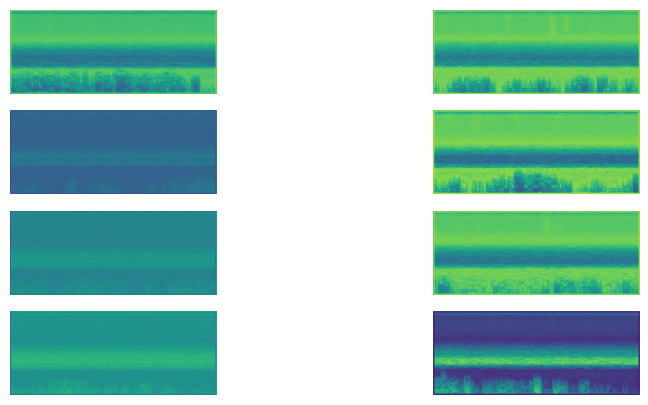

Epoch [1/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [2/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


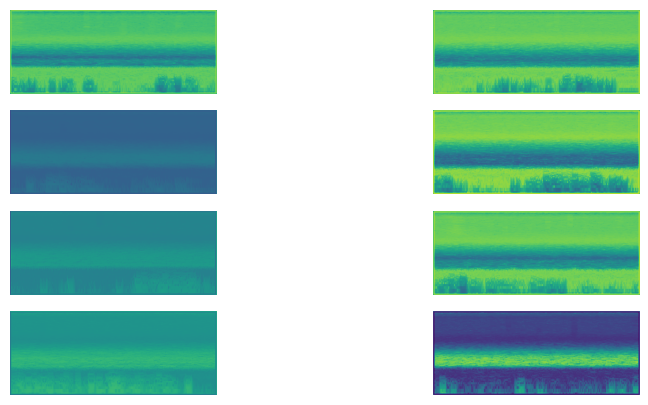

Epoch [2/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [3/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


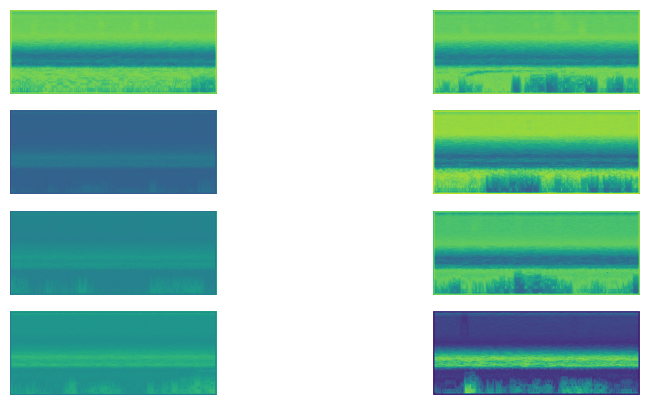

Epoch [3/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [4/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


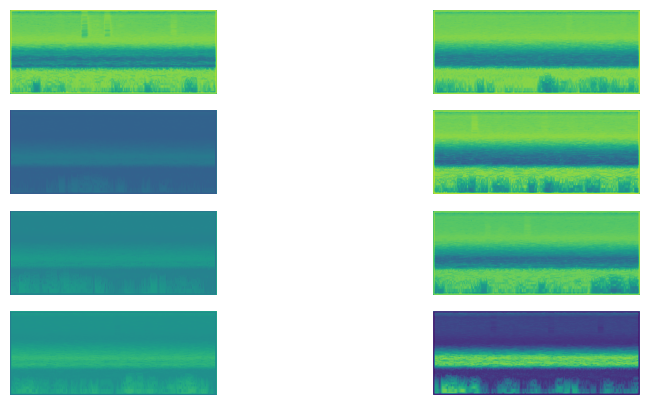

Epoch [4/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [5/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


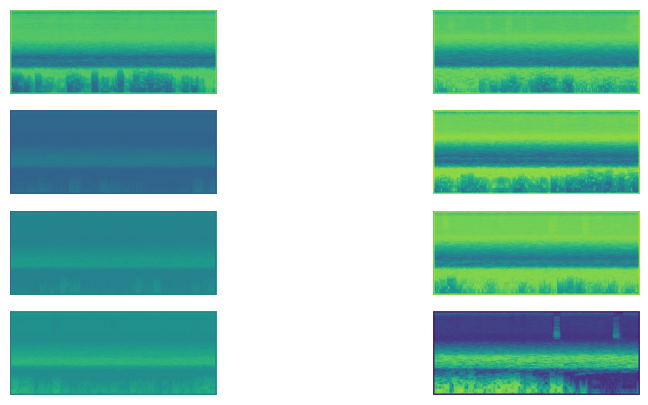

Epoch [5/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [6/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


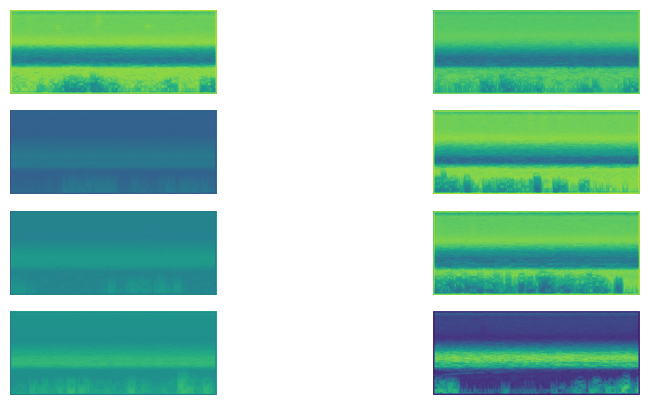

Epoch [6/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [7/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


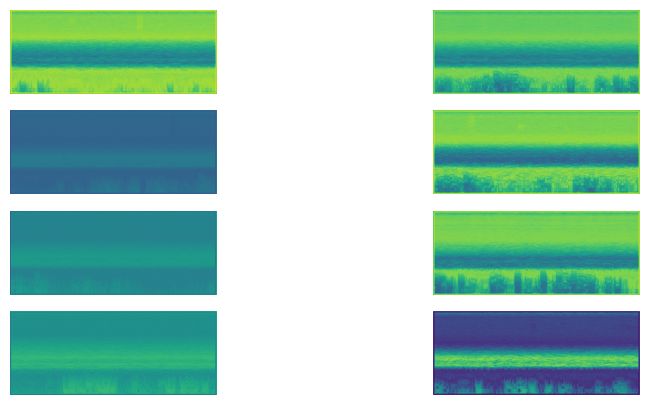

Epoch [7/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [8/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


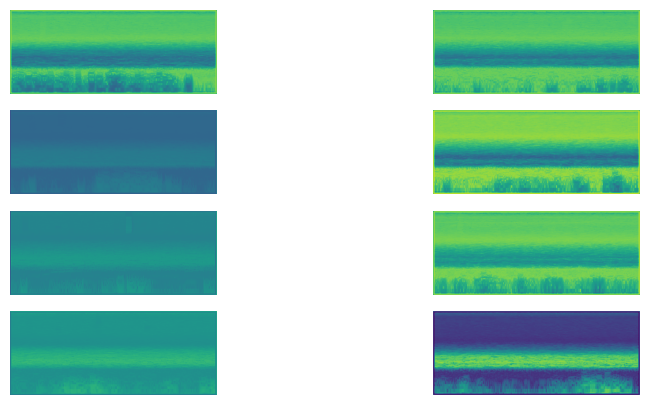

Epoch [8/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [9/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


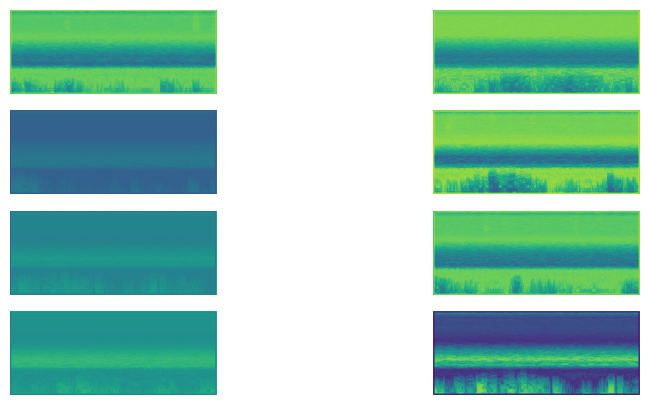

Epoch [9/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [10/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


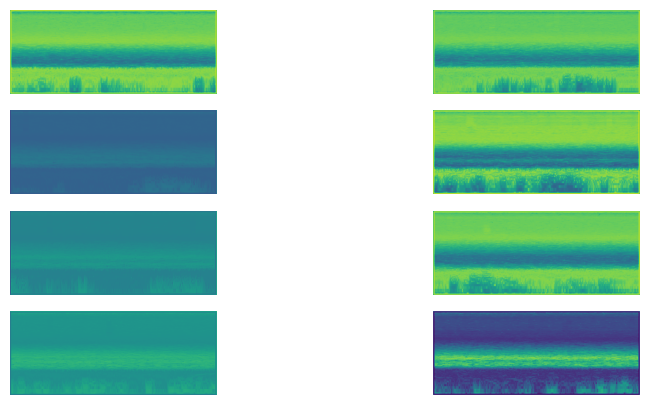

Epoch [10/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [11/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


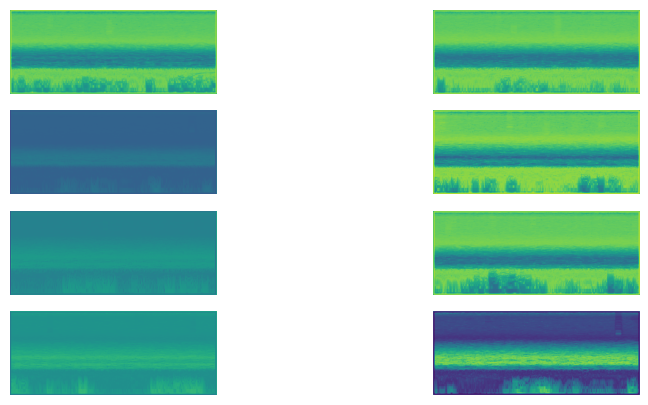

Epoch [11/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [12/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


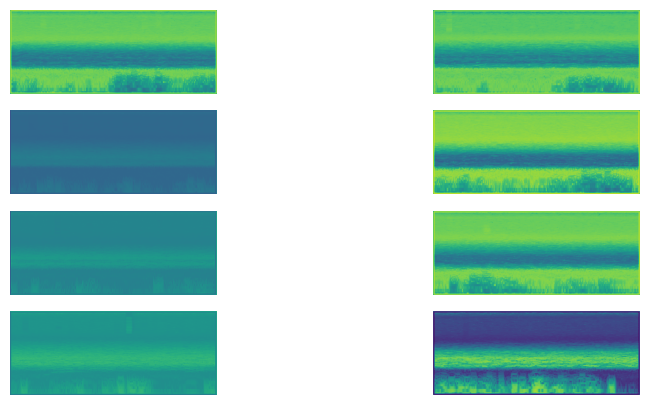

Epoch [12/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [13/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


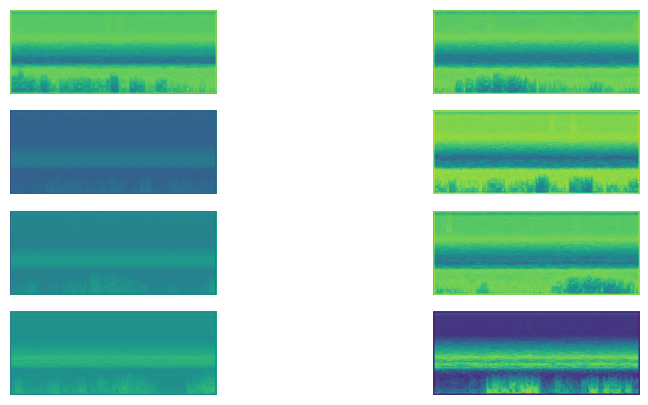

Epoch [13/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [14/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


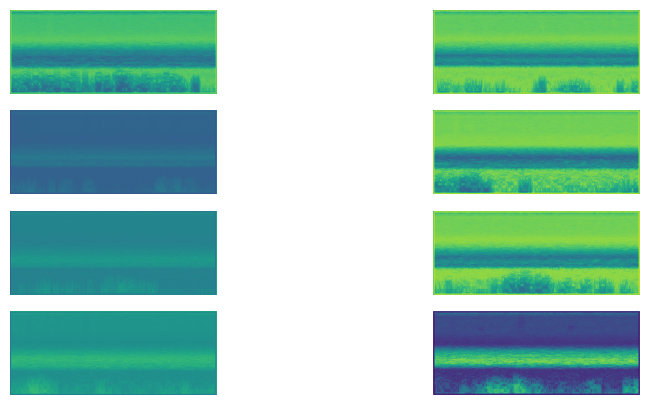

Epoch [14/15], Loss: 0.3133, Accuracy: 100.00%
Epoch [15/15], Step [10/15], Loss: 0.3133
(636, 1570) (3, 3)


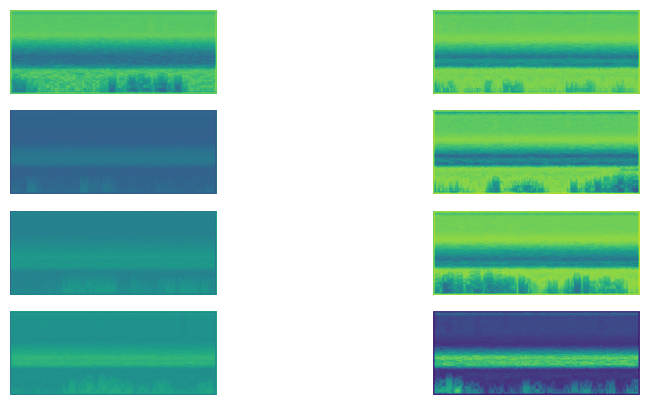

Epoch [15/15], Loss: 0.3133, Accuracy: 100.00%


In [50]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
correct = 0
total = 0

for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        labels = labels.to(device)
        images = images.to(device)
        
        
        images = images.unsqueeze(1)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, 1)[1]).sum().item()
        
        if (i+1) % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))
            
            # Visualize filters from the first convolutional layer
            filters = model.conv_layer1.weight.data.cpu().numpy()
            filters = np.reshape(filters, (8,3,3))
            print(images[0][0, :, :].numpy().shape, filters[0].shape)
            plt.figure(figsize=(10, 5))
            for j in range(filters.shape[0]):  # Assuming out_channels=16 in the first conv layer
                plt.subplot(4, 2, j+1)
                couche = convolve2d(images[j][0, :, :].numpy(), filters[j])
                plt.imshow(couche)
                plt.axis('off')
            plt.show()
        
    accuracy = 100 * correct / total
    print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_epochs, loss.item(), accuracy))

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)

        images = images.unsqueeze(1)
        labels = labels[:,1]
        labels = labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(70, 100 * correct / total))

Accuracy of the network on the 70 train images: 99.58333333333333 %


In [ ]:
torch.save(model, 'model1.pt')

In [ ]:
model = torch.load('model1.pt')

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, weight_decay = 0.005, momentum = 0.9)  

total_step = len(train_loader)

In [ ]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
	#Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        labels = labels.to(device)
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

: 

Idées finales:
passer en input les puissances en log,
utiliser algorithme des chiffres,
passer par les matrices